##Imports

In [ ]:
!pip install transformers torch pandas scikit-learn tqdm
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoModel
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

##Google Drive for Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/My Drive/yelp_review_fine-grained_5_classes_csv"))  #Change to your own path or own method for dataset

['test.csv', 'readme.txt', 'train.csv']


##Dataset

In [ ]:
print(torch.cuda.is_available())  # Should return True if GPU is available

True


In [ ]:
# Load train and test datasets
train_data = pd.read_csv("/content/drive/My Drive/yelp_review_fine-grained_5_classes_csv/train.csv")
test_data = pd.read_csv("/content/drive/My Drive/yelp_review_fine-grained_5_classes_csv/test.csv")

# Rename columns for clarity
train_data.rename(columns={"class_index": "rating", "review_text": "review"}, inplace=True)
test_data.rename(columns={"class_index": "rating", "review_text": "review"}, inplace=True)

print("Train data preview:")
print(train_data.head())

print("Test data preview:")
print(test_data.head())



Train data preview:
   rating                                             review
0       5  dr. goldberg offers everything i look for in a...
1       2  Unfortunately, the frustration of being Dr. Go...
2       4  Been going to Dr. Goldberg for over 10 years. ...
3       4  Got a letter in the mail last week that said D...
4       1  I don't know what Dr. Goldberg was like before...
Test data preview:
   rating                                             review
0       1  I got 'new' tires from them and within two wee...
1       1  Don't waste your time.  We had two different p...
2       1  All I can say is the worst! We were the only 2...
3       1  I have been to this restaurant twice and was d...
4       1  Food was NOT GOOD at all! My husband & I ate h...


In [ ]:
# Split train_data into temporary train and validation datasets
train_data_temp, val_subset = train_test_split(
    train_data, test_size=10000, stratify=train_data['rating'], random_state=42
)

# Split train_data_temp into train_subset
train_subset, _ = train_test_split(
    train_data_temp, train_size=50000, stratify=train_data_temp['rating'], random_state=42
)

# Split test_data into test_subset
test_subset, _ = train_test_split(
    test_data, train_size=10000, stratify=test_data['rating'], random_state=42
)

# Subtract 1 to ensure labels are in the range [0, 4]
train_subset['rating'] = train_subset['rating'] - 1
test_subset['rating'] = test_subset['rating'] - 1
val_subset['rating'] = val_subset['rating'] - 1

#set the classes as int
train_subset['rating'] = train_subset['rating'].astype(int)
test_subset['rating'] = test_subset['rating'].astype(int)
val_subset['rating'] = val_subset['rating'].astype(int)

#reset index
train_subset.reset_index(drop=True, inplace=True)
test_subset.reset_index(drop=True, inplace=True)
val_subset.reset_index(drop=True, inplace=True)

# Print the class distribution for each subset
print("Train Subset Class Distribution:")
print(train_subset['rating'].value_counts())

print("\nValidation Subset Class Distribution:")
print(val_subset['rating'].value_counts())

print("\nTest Subset Class Distribution:")
print(test_subset['rating'].value_counts())

# Print the shapes of the datasets
print("\nTrain Subset Shape:", train_subset.shape)
print("Validation Subset Shape:", val_subset.shape)
print("Test Subset Shape:", test_subset.shape)

Train Subset Class Distribution:
rating
2    10000
3    10000
4    10000
1    10000
0    10000
Name: count, dtype: int64

Validation Subset Class Distribution:
rating
4    2000
0    2000
1    2000
2    2000
3    2000
Name: count, dtype: int64

Test Subset Class Distribution:
rating
0    2000
4    2000
2    2000
1    2000
3    2000
Name: count, dtype: int64

Train Subset Shape: (50000, 2)
Validation Subset Shape: (10000, 2)
Test Subset Shape: (10000, 2)


###Dataset visualization

<ipython-input-11-078d7aaa9fd5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=train_subset, palette="Set2", ax=axes[0])
<ipython-input-11-078d7aaa9fd5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=val_subset, palette="Set2", ax=axes[1])
<ipython-input-11-078d7aaa9fd5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=test_subset, palette="Set2", ax=axes[2])


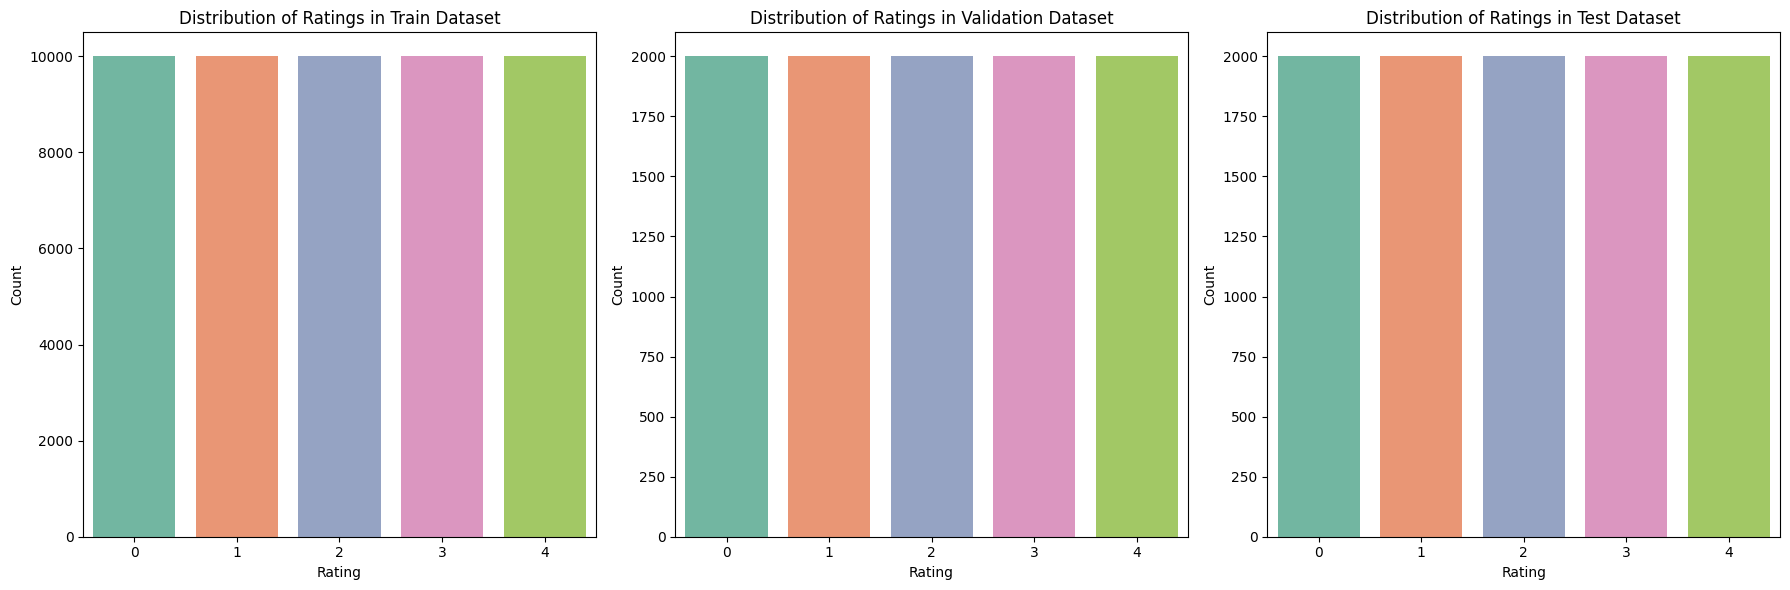

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution of ratings in the train dataset
sns.countplot(x="rating", data=train_subset, palette="Set2", ax=axes[0])
axes[0].set_title("Distribution of Ratings in Train Dataset")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Count")

# Plot the distribution of ratings in the validation dataset
sns.countplot(x="rating", data=val_subset, palette="Set2", ax=axes[1])
axes[1].set_title("Distribution of Ratings in Validation Dataset")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Count")

# Plot the distribution of ratings in the test dataset
sns.countplot(x="rating", data=test_subset, palette="Set2", ax=axes[2])
axes[2].set_title("Distribution of Ratings in Test Dataset")
axes[2].set_xlabel("Rating")
axes[2].set_ylabel("Count")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


<ipython-input-12-bd3edbc519d0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="rating", y="review_length", data=train_data, palette="Set2", ax=axes[0])
<ipython-input-12-bd3edbc519d0>:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=train_data, x="review_length", kde=True, ax=axes[1], palette="Set2")


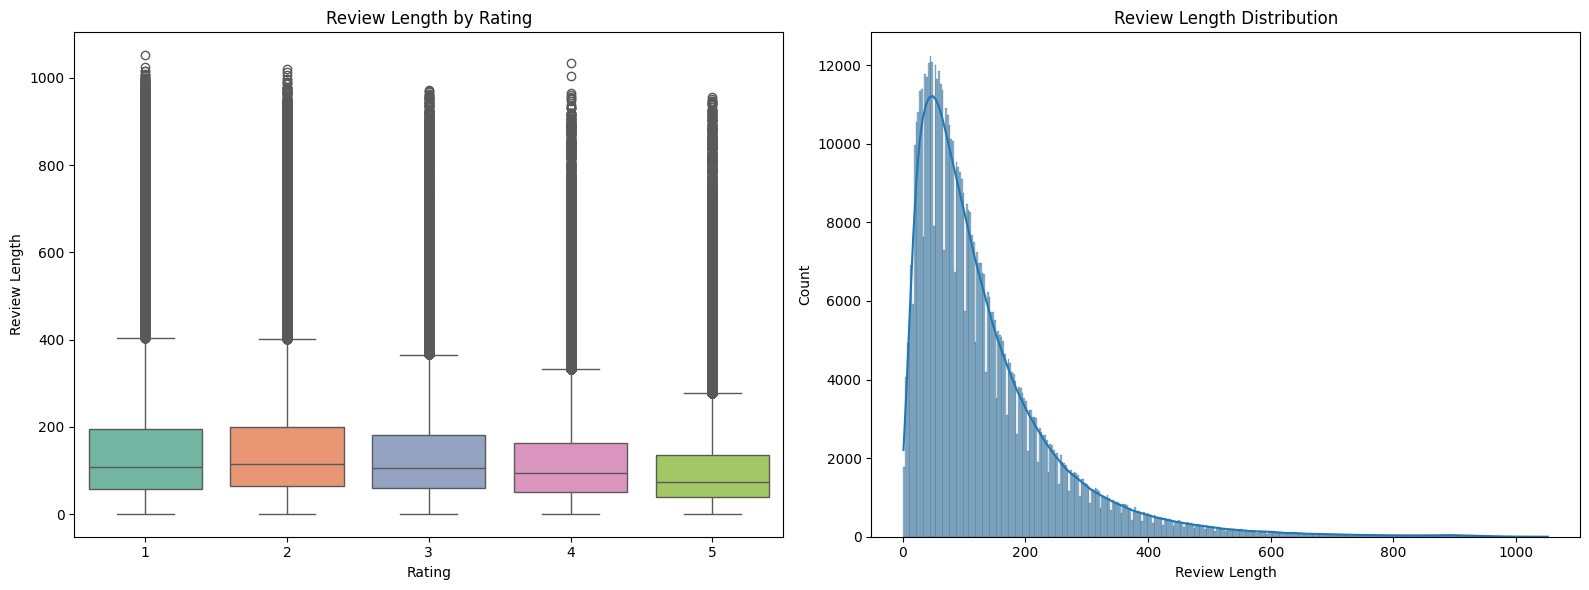

In [ ]:
# Add a column for the length of the reviews
train_data['review_length'] = train_data['review'].apply(lambda x: len(x.split()))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot: Review length by rating
sns.boxplot(x="rating", y="review_length", data=train_data, palette="Set2", ax=axes[0])
axes[0].set_title("Review Length by Rating")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Review Length")

# Histogram: Distribution of review length
sns.histplot(data=train_data, x="review_length", kde=True, ax=axes[1], palette="Set2")
axes[1].set_title("Review Length Distribution")
axes[1].set_xlabel("Review Length")
axes[1].set_ylabel("Count")

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


###Dataset visualization "Word counts"

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
from collections import Counter

customlist = ["like", "got" , "just" , "time"]
# Function to clean and preprocess the text (removing punctuation and stopwords)
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    words = text.split()
    return [word for word in words if word not in ENGLISH_STOP_WORDS and word not in customlist]

# Create cleaned_train_set and cleaned_test_set DataFrames
cleaned_train_set = train_subset.copy()  # Create a copy of train_subset
cleaned_test_set = test_subset.copy()  # Create a copy of test_subset

# Apply text cleaning to both the train and test subsets
cleaned_train_set['cleaned_review'] = train_subset['review'].apply(clean_text)
cleaned_test_set['cleaned_review'] = test_subset['review'].apply(clean_text)

# Function to get the top 10 most common words for each rating/class
def get_top_10_words(rating_class, df):
    class_texts = df[df['rating'] == rating_class]['cleaned_review']
    all_words = [word for text in class_texts for word in text]
    word_counts = Counter(all_words)
    return word_counts.most_common(10)

# Get top 10 words for each class (ratings 1 to 5)
top_10_words_per_class = {}
for class_num in range(0, 5):
    top_10_words_per_class[class_num] = get_top_10_words(class_num, cleaned_train_set) # changed train_subset to cleaned_train_set

# Display the results for each class
for class_num, top_words in top_10_words_per_class.items():
    print(f"Top 10 words for rating {class_num}:")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

Top 10 words for rating 0:
food: 5717
place: 5521
service: 4509
said: 3528
dont: 3418
good: 3218
told: 3194
didnt: 3136
did: 2723
asked: 2691

Top 10 words for rating 1:
food: 7727
place: 6121
good: 6010
service: 4186
really: 3925
dont: 3220
didnt: 3099
ordered: 2910
great: 2523
came: 2495

Top 10 words for rating 2:
good: 8179
food: 6405
place: 5905
really: 3928
service: 3374
great: 3331
pretty: 2874
nice: 2807
dont: 2641
little: 2491

Top 10 words for rating 3:
good: 7398
place: 5765
great: 5363
food: 5218
really: 3346
service: 2807
nice: 2693
little: 2406
pretty: 2039
love: 1993

Top 10 words for rating 4:
great: 5596
place: 5095
food: 4335
good: 3993
service: 2880
best: 2776
love: 2610
really: 2329
ive: 1912
amazing: 1906



Top 20 most common words in all reviews:
food: 29402
good: 28798
place: 28407
great: 18110
service: 17756
really: 15850
dont: 12807
didnt: 11001
im: 10325
nice: 10302
ordered: 9949
did: 9276
came: 9140
people: 9118
order: 8976
little: 8935
went: 8923
restaurant: 8758
pretty: 8584
ive: 8162


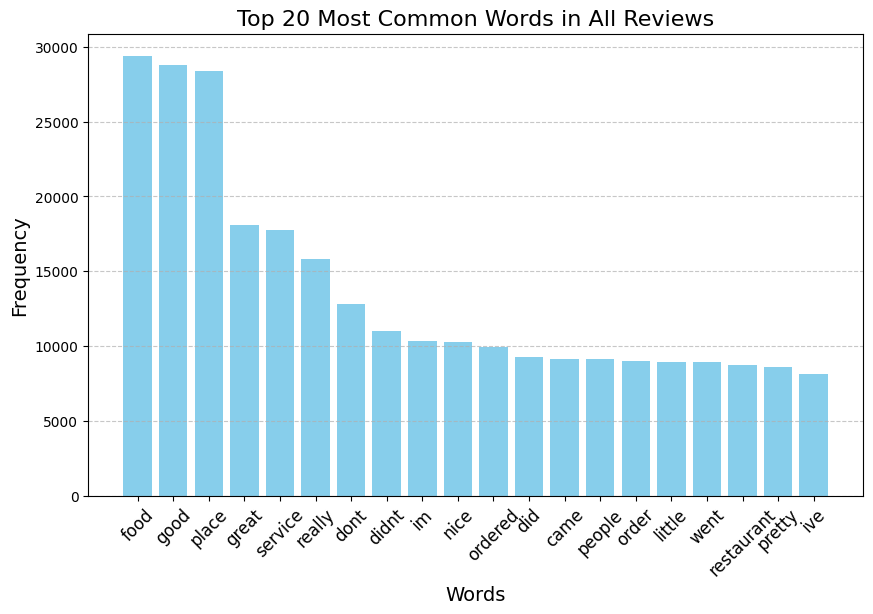

In [ ]:
# Combine all reviews into a single list of words
all_words = [word for text in cleaned_train_set['cleaned_review'] for word in text]

# Get the counts of all words
word_counts = Counter(all_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Print the top 20 words
print("Top 20 most common words in all reviews:")
for word, count in top_20_words:
    print(f"{word}: {count}")

# Visualization
# Extract words and their counts for plotting
words = [word for word, count in top_20_words]
counts = [count for word, count in top_20_words]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title("Top 20 Most Common Words in All Reviews", fontsize=16)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


##Tokenizer

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data function
def tokenize_data(reviews, ratings):
    return tokenizer(
        list(reviews),
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    ), torch.tensor(ratings.values, dtype=torch.long)


# Tokenize datasets
train_inputs, train_labels = tokenize_data(train_subset['review'], train_subset['rating'])
val_inputs, val_labels = tokenize_data(val_subset['review'], val_subset['rating'])
test_inputs, test_labels = tokenize_data(test_subset['review'], test_subset['rating'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Display the first few rows of the tokenized inputs and labels
print("First few tokenized reviews (inputs):")
print(train_inputs['input_ids'][:5])  # Access the 'input_ids' tensor and slice to get the first 5

First few tokenized reviews (inputs):
tensor([[ 101, 2234, 2182,  ..., 2172, 8808,  102],
        [ 101, 1037, 2307,  ..., 1045, 2876,  102],
        [ 101, 1045, 1005,  ...,    0,    0,    0],
        [ 101, 2023, 2173,  ...,    0,    0,    0],
        [ 101, 2234, 1999,  ...,    0,    0,    0]])


###TensorDatasets - batch size

In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

##Model Training

In [ ]:
# Control whether to train or load the model
TRAIN_MODEL = False  # Set to True to train; False to load and evaluate/predict

In [ ]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if TRAIN_MODEL:
    # Initialize model, optimizer, and loss
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=5,
        hidden_dropout_prob=0.2
    ).to(device)

    optimizer = AdamW(model.parameters(), lr= 1.7e-5 , weight_decay=0.01)
    loss_fn = torch.nn.CrossEntropyLoss()

    #Freeze the first 4 layers of BERT encoder
    for param in model.bert.encoder.layer[:4].parameters():
      param.requires_grad = False

    # Early stopping parameters
    patience = 2  # Stop training after 3 epochs with no improvement
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs = 7 # Max number of epochs

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0  # Initialize val_loss
        val_accuracy = 0  # Initialize val_accuracy

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()

                # Calculate accuracy
                preds = torch.argmax(outputs.logits, dim=1)
                val_accuracy += (preds == labels).float().mean().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "/content/drive/My Drive/best_model_50_000.pth")  # Save the best model
            print("Validation loss improved. Model saved.")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break
else:
    # Load the trained model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=5
    ).to(device)
    model.load_state_dict(torch.load("/content/drive/My Drive/best_model_50_000.pth"))
    model.eval()
    print("Loaded trained model from 'best_model.pth'.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-76cff6d783b3>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

Loaded trained model from 'best_model.pth'.


## Finding HyperParameters

In [ ]:
!pip install optuna
import optuna
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:

# Define the objective function for Optuna
def objective(trial, train_loader, val_loader, device, num_epochs=3):
    # Sample hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    dropout_prob = trial.suggest_uniform('dropout_prob', 0.1, 0.3)

    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=5,
        hidden_dropout_prob=dropout_prob
    ).to(device)

    # Initialize optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay= 0.01)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Training loop over multiple epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()

                # Calculate accuracy
                preds = torch.argmax(outputs.logits, dim=1)
                val_accuracy += (preds == labels).float().mean().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)

        # Output validation metrics after each epoch
        print(f"Epoch {epoch + 1}/{num_epochs} - Val Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}")

    return avg_val_loss  # Return the final validation loss after all epochs

# Define the hyperparameter optimization function
def optimize_hyperparameters(train_loader, val_loader, device, n_trials=10, num_epochs=3):
    study = optuna.create_study(direction='minimize')  # Minimize validation loss
    study.optimize(lambda trial: objective(trial, train_loader, val_loader, device, num_epochs=num_epochs), n_trials=n_trials)

    print(f"Best hyperparameters: {study.best_params}")
    print(f"Best validation loss: {study.best_value}")
    return study.best_params

# Example for optimizing hyperparameters over 10 trials and 3 epochs
best_params = optimize_hyperparameters(train_loader, val_loader, device, n_trials=10, num_epochs=5)

[I 2024-12-05 12:55:14,191] A new study created in memory with name: no-name-4728a42a-e0f2-4e45-aa73-d0c972237c66
<ipython-input-23-99ffbd348f29>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
<ipython-input-23-99ffbd348f29>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_prob = trial.suggest_uniform('dropout_prob', 0.1, 0.3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/p

Epoch 1/5 - Val Loss: 1.1407, Accuracy: 0.4955
Epoch 2/5 - Val Loss: 0.9780, Accuracy: 0.5491
Epoch 3/5 - Val Loss: 1.2262, Accuracy: 0.5223
Epoch 4/5 - Val Loss: 1.2386, Accuracy: 0.5134


[I 2024-12-05 12:58:55,598] Trial 0 finished with value: 1.3467852302959986 and parameters: {'lr': 5.35297954189554e-05, 'dropout_prob': 0.10683116506769999}. Best is trial 0 with value: 1.3467852302959986.


Epoch 5/5 - Val Loss: 1.3468, Accuracy: 0.5536


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Val Loss: 1.6405, Accuracy: 0.2188
Epoch 2/5 - Val Loss: 1.6464, Accuracy: 0.1920
Epoch 3/5 - Val Loss: 1.6345, Accuracy: 0.1786
Epoch 4/5 - Val Loss: 1.6216, Accuracy: 0.2188


[I 2024-12-05 13:02:36,299] Trial 1 finished with value: 1.6404412303652083 and parameters: {'lr': 0.0008390335471474203, 'dropout_prob': 0.29312783876572657}. Best is trial 0 with value: 1.3467852302959986.


Epoch 5/5 - Val Loss: 1.6404, Accuracy: 0.1920


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Val Loss: 1.5427, Accuracy: 0.2902
Epoch 2/5 - Val Loss: 1.0757, Accuracy: 0.5045
Epoch 3/5 - Val Loss: 1.3634, Accuracy: 0.4509
Epoch 4/5 - Val Loss: 1.0863, Accuracy: 0.5580


[I 2024-12-05 13:06:18,971] Trial 2 finished with value: 1.5419658081872123 and parameters: {'lr': 6.684205233608484e-05, 'dropout_prob': 0.10748626652038507}. Best is trial 0 with value: 1.3467852302959986.


Epoch 5/5 - Val Loss: 1.5420, Accuracy: 0.5223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[W 2024-12-05 13:06:57,364] Trial 3 failed with parameters: {'lr': 0.00011734115548477867, 'dropout_prob': 0.21903490947194465} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-23-99ffbd348f29>", line 60, in <lambda>
    study.optimize(lambda trial: objective(trial, train_loader, val_loader, device, num_epochs=num_epochs), n_trials=n_trials)
  File "<ipython-input-23-99ffbd348f29>", line 28, in objective
    train_loss += loss.item()
KeyboardInterrupt
[W 2024-12-05 13:06:57,370] Trial 3 failed with value N

KeyboardInterrupt: 

In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Display the first few rows of the tokenized inputs and labels
print("First few tokenized reviews (inputs):")
print(train_inputs['input_ids'][:5])  # Access the 'input_ids' tensor and slice to get the first 5

First few tokenized reviews (inputs):
tensor([[ 101, 2234, 2182,  ..., 2172, 8808,  102],
        [ 101, 1037, 2307,  ..., 1045, 2876,  102],
        [ 101, 1045, 1005,  ...,    0,    0,    0],
        [ 101, 2023, 2173,  ...,    0,    0,    0],
        [ 101, 2234, 1999,  ...,    0,    0,    0]])


In [ ]:
# Control whether to train or load the model
TRAIN_MODEL = False  # Set to True to train; False to load and evaluate/predict

In [ ]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if TRAIN_MODEL:
    # Initialize model, optimizer, and loss
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=5,
        hidden_dropout_prob=0.2
    ).to(device)

    optimizer = AdamW(model.parameters(), lr= 1.7e-5 , weight_decay=0.01)
    loss_fn = torch.nn.CrossEntropyLoss()

    #Freeze the first 4 layers of BERT encoder
    for param in model.bert.encoder.layer[:4].parameters():
      param.requires_grad = False

    # Early stopping parameters
    patience = 2  # Stop training after 3 epochs with no improvement
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs = 7 # Max number of epochs

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0  # Initialize val_loss
        val_accuracy = 0  # Initialize val_accuracy

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()

                # Calculate accuracy
                preds = torch.argmax(outputs.logits, dim=1)
                val_accuracy += (preds == labels).float().mean().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "/content/drive/My Drive/best_model_50_000.pth")  # Save the best model
            print("Validation loss improved. Model saved.")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break
else:
    # Load the trained model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=5
    ).to(device)
    model.load_state_dict(torch.load("/content/drive/My Drive/best_model_50_000.pth"))
    model.eval()
    print("Loaded trained model from 'best_model.pth'.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-76cff6d783b3>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

Loaded trained model from 'best_model.pth'.


## Model evaluation / Dataframe

In [ ]:
import torch
import numpy as np
import pandas as pd

# Initialize device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/best_model_50_000.pth"))
model.eval()

# Cache test set results
test_results = {"logits": [], "probs": [], "true_labels": [], "predictions": [], "texts": []}

# Process test set in a single pass
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass to get logits
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        preds = torch.argmax(probs, dim=1)  # Predicted class labels

        # Save results
        test_results["logits"].append(logits.cpu().numpy())
        test_results["probs"].append(probs.cpu().numpy())
        test_results["true_labels"].append(labels.cpu().numpy())
        test_results["predictions"].append(preds.cpu().numpy())

        # Save original text data if available in test_subset
        for idx_in_batch in range(len(labels)):
            original_text = test_subset.iloc[batch_idx * test_loader.batch_size + idx_in_batch]['review']
            test_results["texts"].append(original_text)

# Convert lists to numpy arrays for easier processing
test_results["logits"] = np.vstack(test_results["logits"])
test_results["probs"] = np.vstack(test_results["probs"])
test_results["true_labels"] = np.concatenate(test_results["true_labels"])
test_results["predictions"] = np.concatenate(test_results["predictions"])

# Optional: Convert to Pandas DataFrame for structured analysis
test_df = pd.DataFrame({
    "text": test_results["texts"],
    "true_label": test_results["true_labels"],
    "prediction": test_results["predictions"],
    "logits": list(test_results["logits"]),
    "probs": list(test_results["probs"]),
})

# Display the first few rows of the DataFrame
test_df.head()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-48-6d1a19737916>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

,text,true_label,prediction,logits,probs
0,SAGE IS NOW UNDER NEW MANAGEMENT!! Food porti...,0,0,"[2.1324685, 1.6572948, 0.17278333, -1.5828129,...","[0.55284214, 0.34374455, 0.077897, 0.013460925..."
1,Tried out this joint since I'm a real ramen lo...,0,1,"[3.413959, 3.4634078, 0.63320374, -2.8047848, ...","[0.4727253, 0.49668857, 0.029305032, 0.0009415..."
2,Superb! My husband and I LOVE Glenway Premium...,4,3,"[-3.3812227, -1.4412383, 0.37270737, 2.701495,...","[0.0013362851, 0.009298734, 0.057044048, 0.585..."
3,"Eh, this market was OK, but it didn't do it fo...",2,2,"[-0.8213199, 2.3303132, 3.055419, -0.65740883,...","[0.01353241, 0.31630933, 0.6531628, 0.01594266..."
4,OK heres the deal...I went here on a sunday ju...,0,0,"[4.7647343, 2.6749473, -0.42279184, -3.017781,...","[0.8849103, 0.10947534, 0.0049429387, 0.000368..."


##Test Loss

In [ ]:
import torch.nn.functional as F

# Define the loss function (same as used during training)
loss_fn = torch.nn.CrossEntropyLoss()

# Extract logits and true labels from the DataFrame
logits = np.vstack(test_df["logits"])  # Convert list of logits to a numpy array
true_labels = test_df["true_label"].values

# Convert to tensors
logits_tensor = torch.tensor(logits, dtype=torch.float32)
true_labels_tensor = torch.tensor(true_labels, dtype=torch.long)

# Compute the test loss
test_loss = loss_fn(logits_tensor, true_labels_tensor).item()
print(f"Test Loss: {test_loss:.4f}")



Test Loss: 0.8480


### Testset visualization / Correlation matrx

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.80      0.77      2000
     Class 1       0.59      0.47      0.52      2000
     Class 2       0.56      0.54      0.55      2000
     Class 3       0.54      0.59      0.56      2000
     Class 4       0.71      0.76      0.74      2000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



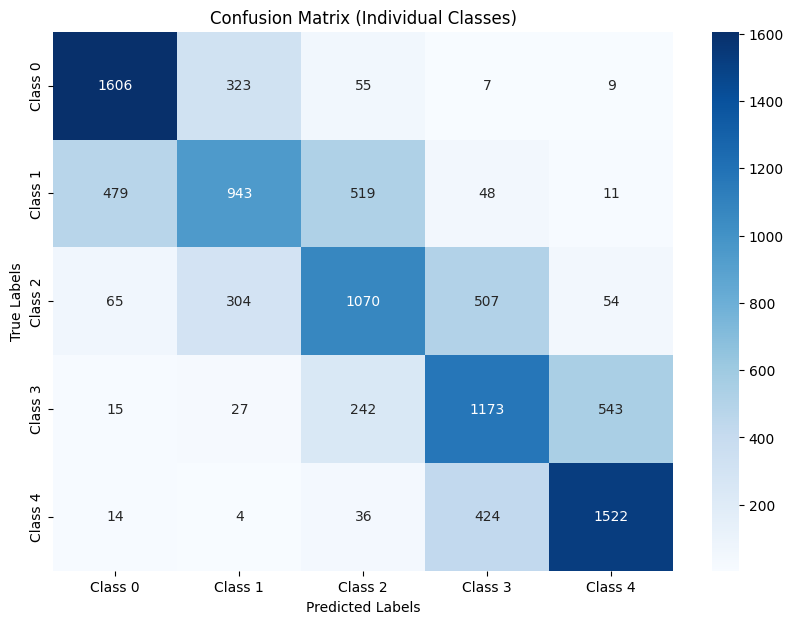

In [ ]:
# Extract true labels and predictions from the test_df DataFrame
all_labels = test_df["true_label"]
all_preds = test_df["prediction"]

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Individual Classes)")
plt.show()


###Grouping Labels together
We do this to get a better reprisentation of the accuracy


Accuracy (Grouped Classes): 0.8083
Classification Report (Grouped Classes):
              precision    recall  f1-score   support

    Negative       0.89      0.84      0.86      4000
     Neutral       0.56      0.54      0.55      2000
    Positive       0.85      0.92      0.88      4000

    accuracy                           0.81     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.81      0.81      0.81     10000



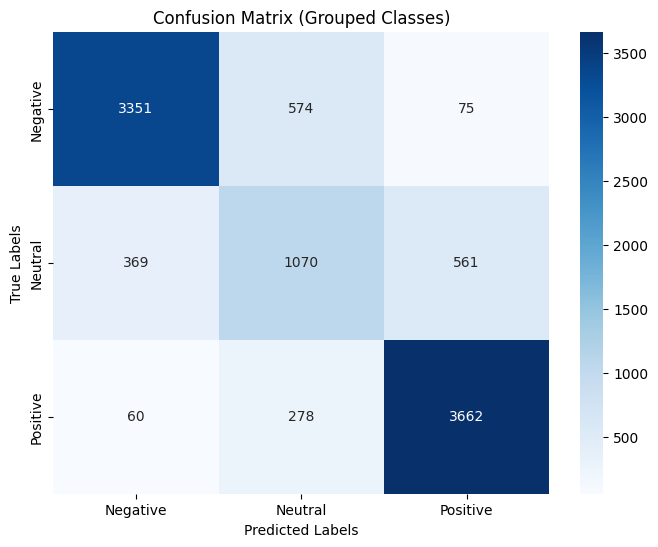

In [ ]:
# Grouped Classes Mapping
def map_to_grouped_class(label):
    if label in [0, 1]:
        return 0  # Negative
    elif label == 2:
        return 1  # Neutral
    elif label in [3, 4]:
        return 2  # Positive

# Map Predictions and Labels to Grouped Classes
grouped_preds = [map_to_grouped_class(p) for p in all_preds]
grouped_labels = [map_to_grouped_class(l) for l in all_labels]

# Calculate Grouped Accuracy
grouped_accuracy = np.mean(np.array(grouped_preds) == np.array(grouped_labels))
print(f"\nAccuracy (Grouped Classes): {grouped_accuracy:.4f}")

# Grouped Classification Report
grouped_classes = ["Negative", "Neutral", "Positive"]
print("Classification Report (Grouped Classes):")
print(classification_report(grouped_labels, grouped_preds, target_names=grouped_classes))

# Grouped Confusion Matrix
grouped_cm = confusion_matrix(grouped_labels, grouped_preds)

# Plot Grouped Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(grouped_cm, annot=True, fmt="d", cmap="Blues", xticklabels=grouped_classes, yticklabels=grouped_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Grouped Classes)")
plt.show()